## Initialization

In [110]:
# Import Braket libraries
from braket.circuits import circuit, Circuit, Gate, Moments
from braket.circuits.instruction import Instruction
from braket.aws import AwsQuantumTask, AwsDevice
from braket.devices import LocalSimulator
import matplotlib.pyplot as plt

# magic word for producing visualizations in notebook
%matplotlib inline
import numpy as np
from math import pi

## Useful Gates Decomposed

In [111]:
@circuit.subroutine(register=True)
def ch(control, target):
    circ = Circuit().rz(target,pi/2).cnot(control,target).rz(target,-pi/2).ry(target,-pi/4).cnot(control,target).ry(target,pi/4).s(control)
    
    return circ

@circuit.subroutine(register=True)
def cry(control, target, angle):
    circ = Circuit().cnot(control,target).ry(target,-angle/2).cnot(control,target).ry(target,angle/2)
    
    return circ

## Purified W state witness, Generation of W state

In [112]:
@circuit.subroutine(register=True)
def w_witness():
    circ = Circuit().ry(4,-2*np.arctan(np.sqrt(3)))
    circ.ch(4,3).cnot(3,4)
    circ.cry(3,1,-2*np.arctan(np.sqrt(1/2))).cnot(3,2).cnot(4,2).cnot(4,1).cnot(4,0).ch(1,0).cnot(0,1).cnot(0,2).cnot(1,2)
    circ.h(5)
    circ.cnot(5,0).cnot(5,1).cnot(5,2).cnot(5,3).cnot(5,4)
    
    return circ

In [113]:
@circuit.subroutine(register=True)
def w_witness_inv():
    circ = Circuit().cnot(5,0).cnot(5,1).cnot(5,2).cnot(5,3).cnot(5,4)
    circ.h(5)
    circ.cnot(1,2).cnot(0,2).cnot(0,1).ch(1,0).cnot(4,0).cnot(4,1).cnot(4,2).cnot(3,2).cry(3,1,2*np.arctan(np.sqrt(1/2)))
    circ.cnot(3,4).ch(4,3)
    circ.ry(4,2*np.arctan(np.sqrt(3)))
    
    return circ

In [114]:
@circuit.subroutine(register=True)
def prep_w_state():
    circ = Circuit().ry(0,2*np.arctan(np.sqrt(1/2))).x(1).cnot(0,1).ch(1,2).cnot(2,1)
    
    return circ

@circuit.subroutine(register=True)
def prep_0_state():
    circ = Circuit()
    
    return circ

@circuit.subroutine(register=True)
def prep_1_state():
    circ = Circuit().x(0).x(1).x(2)
    
    return circ

@circuit.subroutine(register=True)
def prep_w_state_inv():
    circ = Circuit().cnot(2,1).ch(1,2).cnot(0,1).x(1).ry(0,-2*np.arctan(np.sqrt(1/2)))
    
    return circ

@circuit.subroutine(register=True)
def prep_a2_state_inv():
    circ = Circuit().x(1).z(1).cnot(0,1).h(0)
    
    return circ

@circuit.subroutine(register=True)
def prep_b2_state_inv():
    circ = Circuit().x(0).x(2).z(1).cnot(0,1).h(0)
    
    return circ

In [115]:
@circuit.subroutine(register=True)
def purified_estimation(prep_circ):
    tr_rho_w = Circuit()
    tr_rho_w.add_circuit(w_witness())
    tr_rho_w.add_circuit(prep_circ)
        
    return tr_rho_w

# Doublecheck: Quantum Simulator

In [116]:
# set up device: Local Simulator
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-qitkaistuser3" # the name of the bucket
my_prefix = "observable-output" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [117]:
# Quantum circuit for w-state generation estimation
print(prep_w_state())

T  : |   0    |1|2|    3    |    4    |5|   6    |7|
                                                    
q0 : -Ry(1.23)-C------------------------------------
               |                                    
q1 : -X--------X-C---------------------C-S--------X-
                 |                     |          | 
q2 : -Rz(1.57)---X-Rz(-1.57)-Ry(-0.79)-X-Ry(0.79)-C-

T  : |   0    |1|2|    3    |    4    |5|   6    |7|


In [118]:
# Quantum circuit for w-state detection estimation
print(purified_w_detection())

T  : |    0    |1|    2    |    3    |4|   5    |6|7|   8    |9|   10    |11|12|13|   14   |15|   16    |   17    |18|   19   |20|21|22 |23|24|25|   26   |27|   28    |   29    |30|   31   |32|   33    |
                                                                                                                                                                                                           
q0 : ---------------------------------------------------------------------------X--Rz(1.57)-X--Rz(-1.57)-Ry(-0.79)-X--Ry(0.79)-C--C----X------------------------------------------------------C--Ry(-1.23)-
                                                                                |           |                      |           |  |    |                                                      |            
q1 : ----------------------------------------------X-Ry(0.62)-X-Ry(-0.62)----X--|-----------C----------------------C--S--------X--|--C-|-X-----X-----------C----------------------C--S--

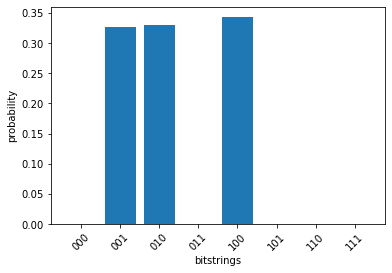

In [119]:
shots = 5000
num_qubits = 3
task = device.run(prep_w_state(), s3_folder, shots)
counts = task.result().measurement_counts

# bitstrings
import numpy

format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]
prob_values = [counts[bitstring_keys[ii]] / shots for ii in range(len(bitstring_keys))]
prob_values = numpy.array(prob_values)

# plot probabalities
plt.bar(bitstring_keys, prob_values);
plt.xlabel('bitstrings');
plt.ylabel('probability');
plt.xticks(rotation=45);

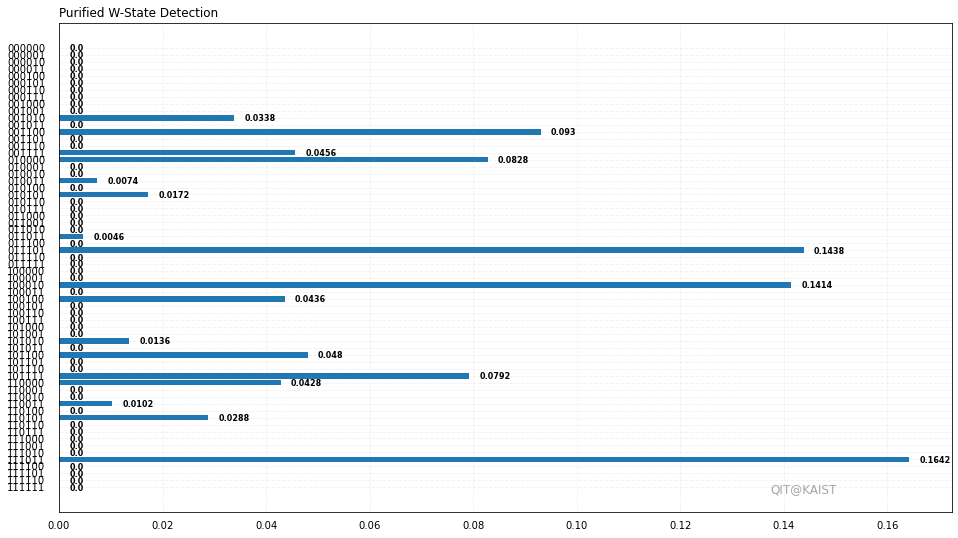

In [127]:
shots = 5000
num_qubits = 6
task = device.run(purified_estimation(prep_w_state_inv()), s3_folder, shots)
counts = task.result().measurement_counts

# bitstrings
import numpy

format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]
prob_values = [counts[bitstring_keys[ii]] / shots for ii in range(len(bitstring_keys))]
prob_values = numpy.array(prob_values)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(bitstring_keys, prob_values)
 
# Remove axes splines
#for s in ['top', 'bottom', 'left', 'right']:
#    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.85,
             str(round((i.get_width()), 5)),
             fontsize = 8, fontweight ='bold',
             color ='black')
 
# Add Plot Title
ax.set_title('Purified W-State Detection', loc ='left')
 
# Add Text watermark
fig.text(0.8, 0.15, 'QIT@KAIST', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

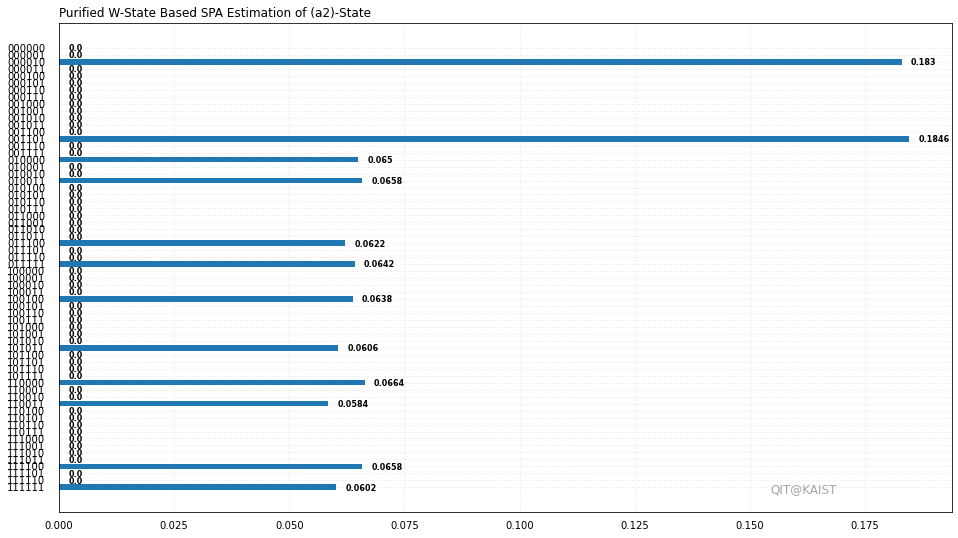

In [128]:
shots = 5000
num_qubits = 6
task = device.run(purified_estimation(prep_a2_state_inv()), s3_folder, shots)
counts = task.result().measurement_counts

# bitstrings
import numpy

format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]
prob_values = [counts[bitstring_keys[ii]] / shots for ii in range(len(bitstring_keys))]
prob_values = numpy.array(prob_values)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(bitstring_keys, prob_values)
 
# Remove axes splines
#for s in ['top', 'bottom', 'left', 'right']:
#    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.85,
             str(round((i.get_width()), 5)),
             fontsize = 8, fontweight ='bold',
             color ='black')
 
# Add Plot Title
ax.set_title('Purified W-State Based SPA Estimation of (a2)-State', loc ='left')
 
# Add Text watermark
fig.text(0.8, 0.15, 'QIT@KAIST', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

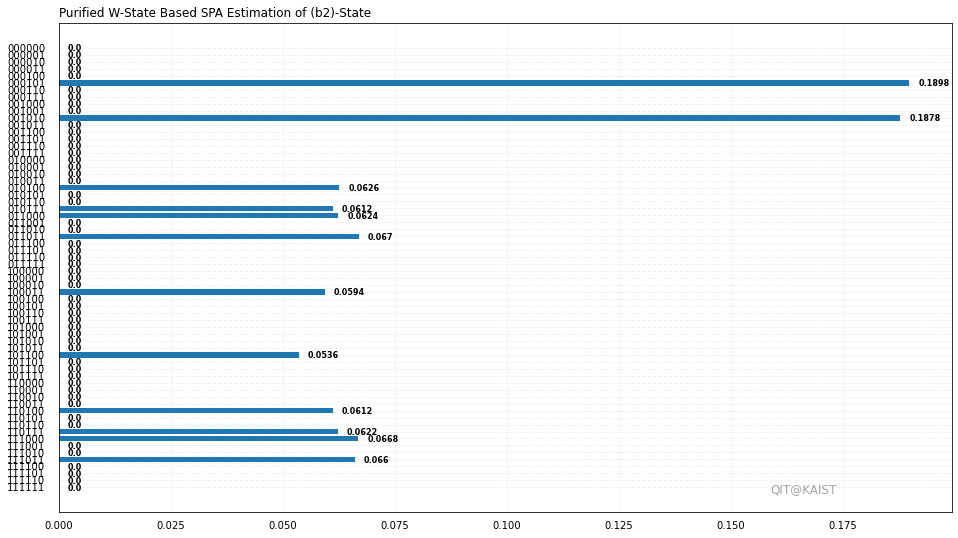

In [126]:
shots = 5000
num_qubits = 6
task = device.run(purified_estimation(prep_b2_state_inv()), s3_folder, shots)
counts = task.result().measurement_counts

# bitstrings
import numpy

format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]
prob_values = [counts[bitstring_keys[ii]] / shots for ii in range(len(bitstring_keys))]
prob_values = numpy.array(prob_values)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(bitstring_keys, prob_values)
 
# Remove axes splines
#for s in ['top', 'bottom', 'left', 'right']:
#    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.85,
             str(round((i.get_width()), 5)),
             fontsize = 8, fontweight ='bold',
             color ='black')
 
# Add Plot Title
ax.set_title('Purified W-State Based SPA Estimation of (b2)-State', loc ='left')
 
# Add Text watermark
fig.text(0.8, 0.15, 'QIT@KAIST', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

# Real Run: Running of IonQ

In [105]:
from braket.aws import AwsDevice

# set up device: Local Simulator
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-qitkaistuser3" # the name of the bucket
my_prefix = "observable_output" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

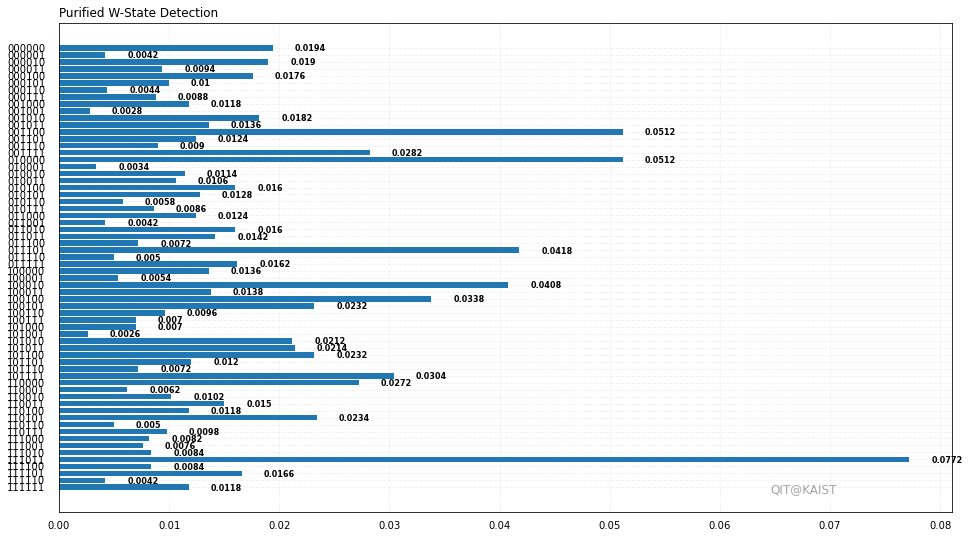

In [106]:
shots = 5000
num_qubits = 6
task = device.run(purified_estimation(prep_w_state_inv()), s3_folder, shots)
counts = task.result().measurement_counts

# bitstrings
import numpy

format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]
prob_values = [counts[bitstring_keys[ii]] / shots for ii in range(len(bitstring_keys))]
prob_values = numpy.array(prob_values)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(bitstring_keys, prob_values)
 
# Remove axes splines
#for s in ['top', 'bottom', 'left', 'right']:
#    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.85,
             str(round((i.get_width()), 5)),
             fontsize = 8, fontweight ='bold',
             color ='black')
 
# Add Plot Title
ax.set_title('Purified W-State Detection', loc ='left')
 
# Add Text watermark
fig.text(0.8, 0.15, 'QIT@KAIST', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

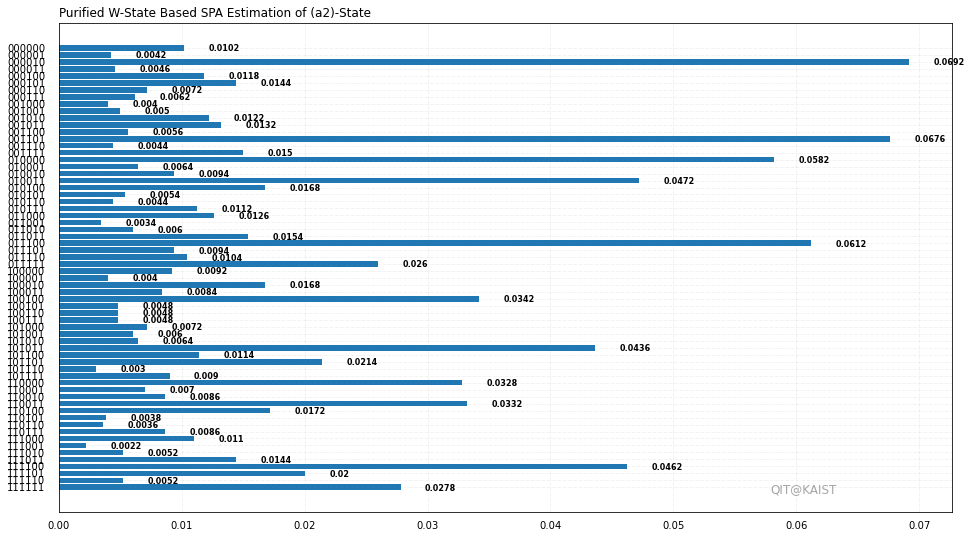

In [107]:
shots = 5000
num_qubits = 6
task = device.run(purified_estimation(prep_a2_state_inv()), s3_folder, shots)
counts = task.result().measurement_counts

# bitstrings
import numpy

format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]
prob_values = [counts[bitstring_keys[ii]] / shots for ii in range(len(bitstring_keys))]
prob_values = numpy.array(prob_values)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(bitstring_keys, prob_values)
 
# Remove axes splines
#for s in ['top', 'bottom', 'left', 'right']:
#    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.85,
             str(round((i.get_width()), 5)),
             fontsize = 8, fontweight ='bold',
             color ='black')
 
# Add Plot Title
ax.set_title('Purified W-State Based SPA Estimation of (a2)-State', loc ='left')
 
# Add Text watermark
fig.text(0.8, 0.15, 'QIT@KAIST', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

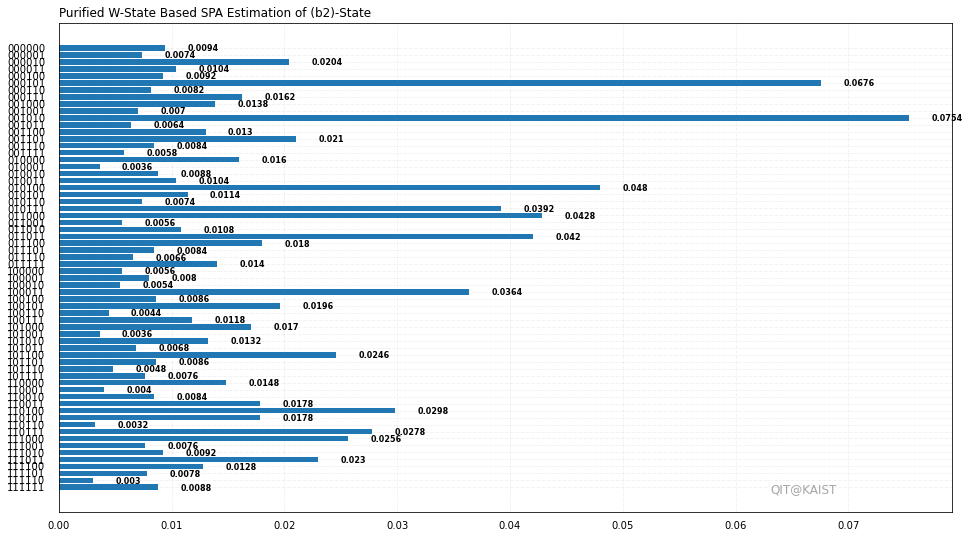

In [108]:
shots = 5000
num_qubits = 6
task = device.run(purified_estimation(prep_b2_state_inv()), s3_folder, shots)
counts = task.result().measurement_counts

# bitstrings
import numpy

format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]
prob_values = [counts[bitstring_keys[ii]] / shots for ii in range(len(bitstring_keys))]
prob_values = numpy.array(prob_values)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(bitstring_keys, prob_values)
 
# Remove axes splines
#for s in ['top', 'bottom', 'left', 'right']:
#    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.85,
             str(round((i.get_width()), 5)),
             fontsize = 8, fontweight ='bold',
             color ='black')
 
# Add Plot Title
ax.set_title('Purified W-State Based SPA Estimation of (b2)-State', loc ='left')
 
# Add Text watermark
fig.text(0.8, 0.15, 'QIT@KAIST', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()